Version 2.0:

1.   Usa 'duration of stay'. en lugar de calcularla con DOA y DOE.

2.   Utiliza unicamente el ultimo registro del paciente segun su fecha de admision

3. Al eliminar registros duplicados, no hace GroupFold para train/test

4. Eliminé la columna bnp por alta cantidad de nulls

Version 3.0:

1. Elimine las columnas creadas en ingenieria de variables. Cuando las quité, mejoraron las metricas, por lo que las variables introducian ruido al modelo

2. Elimine los registros de 'duration of stay' mayores a 15 días. Mejoraron mucho mas las metricas.

Version 4.0:

1. Cambie el clasificador, en lugar de definir el long stay con un percentil,  defini que long stay es > de 7 dìas. Mejoraron las metricas y a nivel operativo conviene esa cantidad de dias en lugar de un percentil

Version 5.0:

1. Use KNN en lugar de la media para imputar los nulls

Version 6.0:

1. Probe Redes neuronales simples al final

In [1]:
# ============================================================
# IMPORTS — utilidades, ciencia de datos, ML y DL
# ============================================================

# Utilidades del sistema
import os, sys, json, math, random, re, warnings
from pathlib import Path
import chardet

# Ciencia de datos
import numpy as np
import pandas as pd

# Visualización y notebooks
import matplotlib.pyplot as plt
from IPython.display import display

# Entorno / Kaggle
import kagglehub

# ------------------------------------------------------------
# Scikit-learn
# ------------------------------------------------------------
# Validación y pipeline
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocesamiento
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator

# Modelos lineales
from sklearn.linear_model import ElasticNet, LogisticRegression

# Métricas
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)

# APIs base y utilidades
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.class_weight import compute_class_weight

# ------------------------------------------------------------
# Gradient Boosting
# ------------------------------------------------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

# ------------------------------------------------------------
# Deep Learning — TensorFlow / Keras
# ------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers


In [2]:
# ============================================================
# CONFIGURACIÓN INICIAL DEL ENTORNO Y PARÁMETROS DEL MODELO
# ============================================================

# Ignorar advertencias para no ensuciar la salida en Colab
warnings.filterwarnings("ignore")

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Parámetros específicos del problema
LONG_STAY_THRESHOLD_DAYS = 7   # 7 dias para determinar LONG STAY

# Nombres de columnas relevantes en el dataset
GROUP_COL = "mrd_no"      # Nro de registro del paciente
DATE_ADM = "d_o_a"        # Fecha de ingreso
DATE_DIS = "d_o_d"        # Fecha de alta
TARGET_REG = "duration_of_stay"   # Variable continua a predecir: tiempo de estadía (en días)
TARGET_BIN = "long_stay"  # Variable binaria a predecir: estancia prolongada (Sí/No)

# Cargar el dataset desde Kaggle
path = kagglehub.dataset_download("ashishsahani/hospital-admissions-data")
file_path = os.path.join(path, "HDHI Admission data.csv")
with open(file_path, "rb") as f:
    raw_data = f.read(100000)
    result = chardet.detect(raw_data)
df = pd.read_csv(file_path, encoding=result["encoding"])

# Inspección inicial del dataset
print(df.shape)
df.head()

Using Colab cache for faster access to the 'hospital-admissions-data' dataset.
(15757, 56)


,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# ============================================================
# FUNCIONES AUXILIARES
# ============================================================

def normalizar_cols(cols):
    """
    Normaliza nombres de columnas a formato snake_case:
    - Elimina espacios iniciales/finales.
    - Elimina caracteres invisibles (ej. \u200b).
    - Sustituye caracteres no alfanuméricos por "_".
    - Colapsa múltiples "_" en uno solo.
    - Pasa todo a minúsculas.
    Ejemplo:
        "D.O.A" -> "d_o_a"
    """

    out = []
    for c in cols:
        c = c.strip()
        c = c.replace("\u200b","")
        c = re.sub(r"[^0-9A-Za-z]+", "_", c)
        c = re.sub(r"_+", "_", c).strip("_").lower()
        out.append(c)
    return out

def corregir_fechas(df):
    # 1) Respaldos: guardamos copias en texto de las columnas originales
    # para no perder la información antes de hacer conversiones.
    df["d_o_a_raw"] = df[DATE_ADM].astype(str)
    df["d_o_d_raw"] = df[DATE_DIS].astype(str)

    # 2) Normalización de la columna "month_year" (ej: "Apr-17", "Apr 2017")
    # Primero intenta parsear con formato fijo "%b-%y".
    mY = pd.to_datetime(df["month_year"], errors="coerce", format="%b-%y")

    # Para los que fallan, intenta de nuevo dejando que Pandas infiera el formato.
    mY = mY.fillna(pd.to_datetime(df["month_year"], errors="coerce", infer_datetime_format=True))

    # Contamos cuántas filas quedaron sin parsear correctamente.
    bad_mY = mY.isna().sum()
    if bad_mY:
        print(f"[Diag] month_year no parseable en {bad_mY} filas")

    # 3) Corrección de fechas de admisión (D.O.A)
    # Generamos dos interpretaciones posibles de la fecha:
    #   doa_dfirst - dayfirst=True (formato D/M/Y)
    #   doa_mfirst - dayfirst=False (formato M/D/Y)
    doa_dfirst = pd.to_datetime(df["d_o_a_raw"], errors="coerce", dayfirst=True)
    doa_mfirst = pd.to_datetime(df["d_o_a_raw"], errors="coerce", dayfirst=False)

    # Comprobamos cuál coincide en mes y año con "month_year".
    match_dfirst = (doa_dfirst.dt.month == mY.dt.month) & (doa_dfirst.dt.year == mY.dt.year)
    match_mfirst = (doa_mfirst.dt.month == mY.dt.month) & (doa_mfirst.dt.year == mY.dt.year)

    # Seleccionamos:
    # - Si dayfirst coincide -> usamos esa fecha.
    # - Si no, pero monthfirst coincide -> usamos esa.
    # - En cualquier otro caso -> usamos la interpretación dayfirst por defecto.
    doa_fixed = doa_dfirst.where(match_dfirst, doa_mfirst.where(match_mfirst, doa_dfirst))
    df["d_o_a"] = doa_fixed

    # 4) Corrección de fechas de alta (D.O.D)
    # Igual que antes, generamos dos interpretaciones (dayfirst y monthfirst).
    dod_dfirst = pd.to_datetime(df["d_o_d_raw"], errors="coerce", dayfirst=True)
    dod_mfirst = pd.to_datetime(df["d_o_d_raw"], errors="coerce", dayfirst=False)

    # Validamos que la fecha de alta sea >= fecha de ingreso.
    cand1_valid = dod_dfirst >= df[DATE_ADM]
    cand2_valid = dod_mfirst >= df[DATE_ADM]

    # Calculamos la diferencia absoluta de días con respecto a la fecha de ingreso.
    # Esto ayuda a elegir la fecha más lógica si ambas son válidas.
    diff1 = (dod_dfirst - df[DATE_ADM]).abs()
    diff2 = (dod_mfirst - df[DATE_ADM]).abs()

    # Regla de elección:
    # - Usamos monthfirst si es válido y:
    #   a) dayfirst no es válido, o
    #   b) la diferencia con la fecha de ingreso es menor.
    choose2 = cand2_valid & (~cand1_valid | (diff2 < diff1))

    # Construimos la fecha final de alta:
    # - Si corresponde elegir monthfirst -> la usamos.
    # - Si hay nulos, completamos primero con monthfirst y luego con dayfirst.
    dod_fixed = dod_dfirst.mask(choose2, dod_mfirst)
    dod_fixed = dod_fixed.fillna(dod_mfirst).fillna(dod_dfirst)
    df[DATE_DIS] = dod_fixed

    return df

In [4]:
# Eliminamos los pacientes con alta contra indicacion medica, ya que ensucian el LOS

df = df[df['OUTCOME'] != 'DAMA']

In [5]:
# ============================================================
# PREPROCESAMIENTO INICIAL DEL DATASET
# ============================================================

# 1) Normalización de nombres de columnas
df.columns = normalizar_cols(df.columns)

# 2) Inspección del dataset tras normalización
print("Nulos por columna:")
print(df.isnull().sum().sort_values(ascending = False))

# 3) Parseo de fechas de admisión y alta
df = corregir_fechas(df)

# 4) Eliminar casos en que la fecha de alta < fecha de ingreso
mask_bad = df[DATE_DIS] < df[DATE_ADM]
print("Registros con alta < ingreso:", mask_bad.sum())
df = df[~mask_bad].copy()

print("Dataset limpio:", df.shape)

Nulos por columna:
bnp                                8050
ef                                 1431
glucose                             632
platelets                           243
tlc                                 238
hb                                  218
creatinine                          211
urea                                204
type_of_admission_emergency_opd       0
rural                                 0
gender                                0
age                                   0
d_o_d                                 0
month_year                            0
duration_of_intensive_unit_stay       0
duration_of_stay                      0
htn                                   0
dm                                    0
alcohol                               0
smoking                               0
outcome                               0
sno                                   0
d_o_a                                 0
mrd_no                                0
prior_cmp            

In [6]:
# ============================================================
# Pre procesamiento de datos
# ============================================================

# Eliminacion de registros de estancia mayores de 15 dias
df = df[df['duration_of_stay'] <= 15]

# Eliminacion de la columna 'bnp' por alta cantidad de nulls
df = df.drop(columns=['bnp'])

In [7]:
# ============================================================
# Conservar solo la última admisión por paciente
# ============================================================

# Cantidad inicial de registros
print("Cantidad inicial de registros:", len(df))

# Convertir a datetime si aún no lo está

# Ordenar por fecha de admisión
df = df.sort_values(by=["mrd_no", "d_o_a_raw"])

# Conservar solo la última admisión por paciente
df = df.drop_duplicates(subset=["mrd_no"], keep="last")

# Cantidad después del tratamiento
print("Cantidad después de conservar última admisión:", len(df))


Cantidad inicial de registros: 14166
Cantidad después de conservar última admisión: 11146


In [8]:
# ============================================================
# DEFINICIÓN DEL TARGET Y SPLIT TRAIN/TEST
# ============================================================

# Etiqueta TARGET REG

df['TARGET_REG'] = df['duration_of_stay']

#  Etiqueta TARGET BIN de long stay > 5 dias

df["TARGET_BIN"] = (df["duration_of_stay"] > LONG_STAY_THRESHOLD_DAYS).astype(int)


In [9]:
# ============================================================
# BASELINES: MÉTRICAS INICIALES PARA REGRESIÓN Y CLASIFICACIÓN
# ============================================================
# Funciones auxiliares y baselines para comparar con los modelos avanzados

def recall_at_topk(y_true, y_score, k):
    """
    Calcula el recall en el top-k:
    - Ordena instancias por score descendente.
    - Toma las k con mayor score.
    - Mide qué proporción de verdaderos positivos
      quedaron dentro de esas k.
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = int(k)
    if k <= 0:
        return 0.0

    top_idx = np.argsort(-y_score)[:k]  # índices ordenados
    tp_in_topk = y_true[top_idx].sum()  # verdaderos positivos en top-k
    total_pos = y_true.sum()
    return float(tp_in_topk / total_pos) if total_pos > 0 else 0.0



# ------------------------------------------------------------
# Función de evaluación (para reusar en todos los modelos)
# ------------------------------------------------------------

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el MAPE (Mean Absolute Percentage Error).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def eval_regressor(pipeline, X_te, y_te):
    """
    Evalúa un regresor y devuelve métricas MAE, RMSE y MAPE.
    """
    pred = pipeline.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    mse = mean_squared_error(y_te, pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_te, pred)
    return {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}, pred


# ------------------------------------------------------------
# Baseline de regresión
# ------------------------------------------------------------

def baseline_regresion(train, test):
    global_median = float(train[TARGET_REG].median())
    y_pred = pd.Series(global_median, index=test.index)

    mae  = mean_absolute_error(test[TARGET_REG], y_pred)
    rmse = float(np.sqrt(mean_squared_error(test[TARGET_REG], y_pred)))
    mape = mean_absolute_percentage_error(test[TARGET_REG], y_pred)
    return {"mae": float(mae), "rmse": rmse, "mape": float(mape)}, y_pred


# ------------------------------------------------------------
# Baseline de clasificación
# ------------------------------------------------------------

def baseline_clasificacion(train, test):
    train = train.copy()
    train[TARGET_BIN] = (train[TARGET_REG] > LONG_STAY_THRESHOLD_DAYS).astype(int)

    global_p = float(train[TARGET_BIN].mean())
    y_score = pd.Series(global_p, index=test.index)

    ap = float(average_precision_score(test[TARGET_BIN], y_score))
    roc = float(roc_auc_score(test[TARGET_BIN], y_score))
    k20 = max(1, int(0.2 * len(test)))
    rec_at_20 = float(recall_at_topk(test[TARGET_BIN], y_score, k=k20))

    return {"ap": ap, "roc_auc": roc, "recall_at_20": rec_at_20}, y_score


In [10]:
# ============================================================
# PIPELINE DE PREPROCESAMIENTO
# ============================================================


num_features = [
    'age','smoking','alcohol','dm','htn','cad','prior_cmp','ckd','hb','glucose','creatinine',
    'ef','raised_cardiac_enzymes','severe_anaemia','anaemia','stable_angina',
    'acs','stemi','atypical_chest_pain','heart_failure','hfref','hfnef','valvular','chb','sss','aki',
    'cva_infract','cva_bleed','af','vt','psvt','congenital','uti','neuro_cardiogenic_syncope','orthostatic',
    'infective_endocarditis','dvt','cardiogenic_shock','shock','pulmonary_embolism',
    'tlc','platelets','urea'
]

cat_features = [
    'gender','rural','type_of_admission_emergency_opd'
]


TEXTOS_EN_NUMEROS = {"EMPTY", "", "NA", "N/A", "None", "null", "Null", "NULL", "-"}

def to_numeric_matrix(X):
    Xdf = pd.DataFrame(X)
    Xdf = Xdf.replace(list(TEXTOS_EN_NUMEROS), np.nan)
    for c in Xdf.columns:
        Xdf[c] = pd.to_numeric(Xdf[c], errors="coerce")
    return Xdf.values


num_transformer = Pipeline(steps=[
    ("to_numeric", FunctionTransformer(to_numeric_matrix, feature_names_out="one-to-one")),
    ("knn_imp", KNNImputer(n_neighbors=10, weights="distance", metric="nan_euclidean")),
    ("scaler", StandardScaler())
])

# Indicadores de missing (equivalente a add_indicator=True), en paralelo:
num_missing_flags = Pipeline(steps=[
    ("to_numeric", FunctionTransformer(to_numeric_matrix, feature_names_out="one-to-one")),
    ("miss_ind", MissingIndicator(features="all"))
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ------------------------------------------------------------
# 3) ColumnTransformer
#    Une ambos pipelines en un solo preprocesador.
# ------------------------------------------------------------

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("num_miss", num_missing_flags, num_features),  # agrega columnas binarias de faltantes
        ("cat", cat_transformer, cat_features),
    ],
    remainder="drop"
)


In [11]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, average_precision_score, roc_auc_score
import numpy as np

# ----- Config -----
TEST_SIZE    = 0.20
LONG_TH      = LONG_STAY_THRESHOLD_DAYS

df_ = df.copy()
# Si no existe, creamos la etiqueta binaria (no genera fuga; es un umbral fijo)
if TARGET_BIN not in df_.columns:
    df_[TARGET_BIN] = (df_["TARGET_REG"] > LONG_TH).astype(int)

# ----- Split externo: train / test (TEST queda guardado para el final) -----
train_df, test_df = train_test_split(
    df_,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True  # si tenés temporalidad, reemplazar por split temporal
    # stratify=df_[TARGET_BIN]  # opcional; no necesario si no está desbalanceado
)

print(f"Train: {train_df.shape} | TEST (hold-out): {test_df.shape}")

# (Opcional) Guardar el hold-out para no tocarlo por accidente
# test_df.to_parquet('test_holdout.parquet')

# ----- CV interna SOLO sobre train_df -----
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Acumuladores de métricas (baselines)
bl_reg_mae, bl_reg_rmse = [], []
bl_cls_ap, bl_cls_auc, bl_cls_recall20 = [], [], []

# Acumuladores de métricas (modelos)
mdl_reg_mae, mdl_reg_rmse = [], []
mdl_cls_ap, mdl_cls_auc, mdl_cls_recall20 = [], [], []

for tr_idx, te_idx in kf.split(train_df):
    tr_df = train_df.iloc[tr_idx].copy()
    te_df = train_df.iloc[te_idx].copy()

    # Re-etiquetar por fold (mismo criterio fijo)
    tr_df[TARGET_BIN] = (tr_df['TARGET_REG'] > LONG_TH).astype(int)
    te_df[TARGET_BIN] = (te_df['TARGET_REG'] > LONG_TH).astype(int)

    # ---------- Baselines ----------
    # REGRESIÓN
    reg_metrics, reg_pred = baseline_regresion(tr_df, te_df)
    bl_reg_mae.append(reg_metrics["mae"])
    bl_reg_rmse.append(reg_metrics["rmse"])

    # CLASIFICACIÓN
    cls_metrics, cls_score = baseline_clasificacion(tr_df, te_df)
    bl_cls_ap.append(cls_metrics["ap"])
    bl_cls_auc.append(cls_metrics["roc_auc"])
    bl_cls_recall20.append(cls_metrics["recall_at_20"])

    # ---------- MODELOS ----------
    # --- REGRESIÓN (ElasticNet) ---
    X_tr_reg = tr_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_tr_reg = tr_df['TARGET_REG']
    X_te_reg = te_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_te_reg = te_df['TARGET_REG']

    reg_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
    ])
    reg_pipe.fit(X_tr_reg, y_tr_reg)
    y_pred_reg = reg_pipe.predict(X_te_reg)

    mdl_reg_mae.append(mean_absolute_error(y_te_reg, y_pred_reg))
    mdl_reg_rmse.append(np.sqrt(mean_squared_error(y_te_reg, y_pred_reg)))

    # --- CLASIFICACIÓN (LogisticRegression) ---
    X_tr_cls = tr_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_tr_cls = tr_df[TARGET_BIN].astype(int)
    X_te_cls = te_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_te_cls = te_df[TARGET_BIN].astype(int)

    cls_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=1000))
    ])
    cls_pipe.fit(X_tr_cls, y_tr_cls)
    y_proba = cls_pipe.predict_proba(X_te_cls)[:, 1]

    mdl_cls_ap.append(average_precision_score(y_te_cls, y_proba))
    mdl_cls_auc.append(roc_auc_score(y_te_cls, y_proba))
    k20 = max(1, int(0.2 * len(y_te_cls)))
    mdl_cls_recall20.append(recall_at_topk(y_te_cls, y_proba, k=k20))

# ----- Resultados promedio (CV interna) -----
print("=== Baselines (promedio 5-fold en TRAIN) ===")
print("Reg — MAE:", np.mean(bl_reg_mae), "RMSE:", np.mean(bl_reg_rmse))
print("Cls — AP:", np.mean(bl_cls_ap), "ROC-AUC:", np.mean(bl_cls_auc), "Recall@20%:", np.mean(bl_cls_recall20))

print("\n=== Modelos (promedio 5-fold en TRAIN) ===")
print("Reg — MAE:", np.mean(mdl_reg_mae), "RMSE:", np.mean(mdl_reg_rmse))
print("Cls — AP:", np.mean(mdl_cls_ap), "ROC-AUC:", np.mean(mdl_cls_auc), "Recall@20%:", np.mean(mdl_cls_recall20))

# ----- MÁS ADELANTE -----
# Cuando quieras evaluar externamente:
# 1) Reentrenás el mejor pipeline con TODO train_df
# 2) Evaluás UNA SOLA VEZ sobre test_df (guardado arriba)


Train: (8916, 60) | TEST (hold-out): (2230, 60)
=== Baselines (promedio 5-fold en TRAIN) ===
Reg — MAE: 2.496295921369989 RMSE: 3.2453803324270076
Cls — AP: 0.24719529739014962 ROC-AUC: 0.5 Recall@20%: 0.1939965053797367

=== Modelos (promedio 5-fold en TRAIN) ===
Reg — MAE: 2.519781856343814 RMSE: 3.142760874110862
Cls — AP: 0.44862170461848383 ROC-AUC: 0.7406758532118728 Recall@20%: 0.38978722900061746


In [12]:
def bad_num_cols(df, num_cols):
    bad = {}
    for c in num_cols:
        if c in df.columns:
            s = df[c]
            # dtypes objeto o mezclados
            if s.dtype == "object":
                bad[c] = s.value_counts(dropna=False).head(5).to_dict()
            else:
                # intenta convertir por si hay strings camuflados
                sc = pd.to_numeric(s, errors="coerce")
                if sc.isna().sum() > s.isna().sum():  # hubo strings no numéricos
                    bad[c] = s[~s.astype(str).str.match(r"^-?\d+(\.\d+)?$", na=True)].head(5).tolist()
    return bad

bad = bad_num_cols(X_tr_reg, num_features)
print("Columnas numéricas con strings:", bad)  # verás 'EMPTY', '', 'NA', etc.

Columnas numéricas con strings: {'hb': {'13.9': 149, '13.1': 144, '12.6': 143, '13.8': 142, '13.3': 141}, 'glucose': {nan: 345, '110': 138, '98': 111, '104': 97, '100': 94}, 'creatinine': {'0.8': 762, '0.7': 664, '0.9': 638, '0.6': 473, '1': 428}, 'ef': {'60': 2109, nan: 703, '35': 393, '30': 364, '45': 349}, 'tlc': {nan: 131, '8.4': 100, '8.6': 96, '7.9': 96, '8.3': 94}, 'platelets': {nan: 132, '150': 100, '210': 44, '215': 43, '184': 43}, 'urea': {'26': 232, '27': 218, '24': 213, '30': 212, '22': 208}}


ElasticNet [CV-Train] best_params={'model__alpha': 0.01, 'model__l1_ratio': 0.1}  MAE=2.1644
ElasticNet [CV-Train]: MAE=2.1644  RMSE=2.8113  MAPE=56.50%
XGBRegressor [CV-Train]: MAE=2.1390  RMSE=2.7704  MAPE=55.58%
LGBMRegressor [CV-Train]: MAE=2.1147  RMSE=2.7658  MAPE=53.94%
NeuralNet [CV-Train]: MAE=2.1433  RMSE=2.7981  MAPE=55.09%


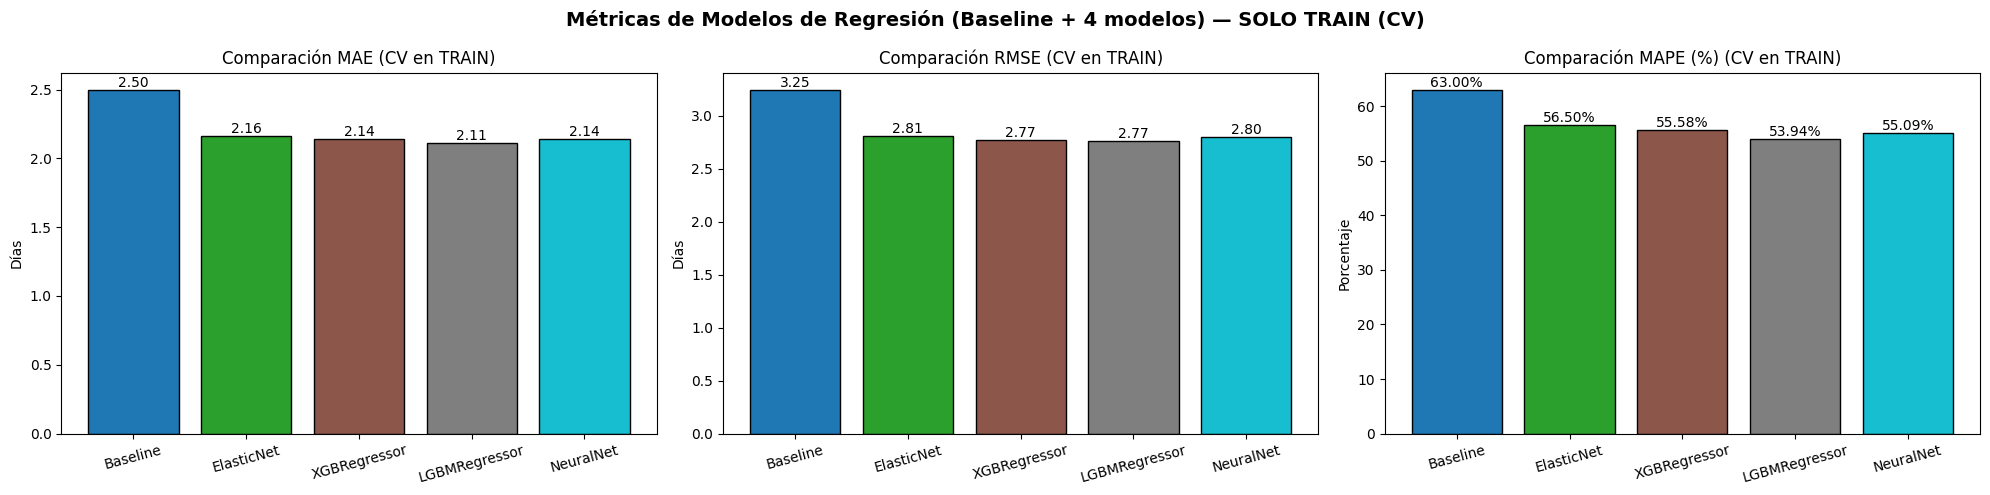

In [13]:
# ============================================================
# COMÚN (config, helpers, preparación de datos) + REGRESIÓN
# ============================================================

# -----------------------------
# 0) Config y helpers COMUNES
# -----------------------------
CV_SPLITS     = 5
RANDOM_STATE  = RANDOM_STATE
LONG_TH       = LONG_STAY_THRESHOLD_DAYS

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def eval_from_proba(y_true, proba):
    ap  = average_precision_score(y_true, proba)
    roc = roc_auc_score(y_true, proba)
    k   = max(1, int(0.2 * len(y_true)))
    rec = float(recall_at_topk(y_true, proba, k))
    return {"ap": float(ap), "roc_auc": float(roc), "recall_at_20": rec}

# Semillas
tf.keras.utils.set_random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

densifier = FunctionTransformer(to_dense, feature_names_out="one-to-one")

# -----------------------------
# 1) Preparar TRAIN
# -----------------------------
train_df_ = train_df.copy()
if TARGET_BIN not in train_df_.columns:
    train_df_[TARGET_BIN] = (train_df_[TARGET_REG] > LONG_TH).astype(int)

X_train     = train_df_.drop([TARGET_REG, TARGET_BIN], axis=1)
y_train_reg = train_df_[TARGET_REG]
y_train_bin = train_df_[TARGET_BIN].astype(int)

# Splitter K-Fold compartido
kf = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# -----------------------------
# 2) Baseline (promedio CV en TRAIN) — REGRESIÓN
# -----------------------------
bl_mae, bl_rmse, bl_mape = [], [], []
for tr_idx, te_idx in kf.split(train_df_):
    tr_df = train_df_.iloc[tr_idx].copy()
    te_df = train_df_.iloc[te_idx].copy()
    tr_df[TARGET_BIN] = (tr_df[TARGET_REG] > LONG_TH).astype(int)
    te_df[TARGET_BIN] = (te_df[TARGET_REG] > LONG_TH).astype(int)
    reg_metrics, _ = baseline_regresion(tr_df, te_df)
    bl_mae.append(reg_metrics["mae"])
    bl_rmse.append(reg_metrics["rmse"])
    bl_mape.append(reg_metrics["mape"])

base_reg_metrics = {
    "mae":  np.mean(bl_mae),
    "rmse": np.mean(bl_rmse),
    "mape": np.mean(bl_mape),
}

# -----------------------------
# 3) ElasticNet con GridSearchCV (solo TRAIN)
# -----------------------------
enet = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

param_enet = {
    "model__alpha": [0.01, 0.1, 1.0],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}

gs_enet = GridSearchCV(
    estimator=enet,
    param_grid=param_enet,
    scoring="neg_mean_absolute_error",
    cv=kf,
    n_jobs=-1,
    refit=True
)
gs_enet.fit(X_train, y_train_reg)
best_enet = gs_enet.best_estimator_

# OOF para métricas comparables
y_oof_enet = cross_val_predict(best_enet, X_train, y_train_reg, cv=kf, n_jobs=-1)
enet_metrics = {
    "mae":  mean_absolute_error(y_train_reg, y_oof_enet),
    "rmse": np.sqrt(mean_squared_error(y_train_reg, y_oof_enet)),
    "mape": mape(y_train_reg, y_oof_enet),
}
print(f"ElasticNet [CV-Train] best_params={gs_enet.best_params_}  MAE={enet_metrics['mae']:.4f}")

# ==========================
#  4) NN Regressor (Pipeline)
# ==========================
def build_nn_model(input_dim, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3):
    inputs = tf.keras.Input(shape=(input_dim,), name="features")
    x = inputs
    for i in range(hidden_layers):
        x = layers.Dense(
            hidden_units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2),
            name=f"dense_{i+1}"
        )(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout, name=f"dropout_{i+1}")(x)
    outputs = layers.Dense(1, name="y")(x)
    model = tf.keras.Model(inputs, outputs, name="nn_regressor")
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae", "mse"])
    return model

class KerasRegressorSK(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4,
                 lr=1e-3, epochs=100, batch_size=256, validation_split=0.1,
                 patience_es=10, patience_rlr=5, verbose=0, random_state=None):
        self.hidden_units = hidden_units
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.l2 = l2
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.patience_es = patience_es
        self.patience_rlr = patience_rlr
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None
        self.input_dim_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)
        input_dim = X.shape[1]
        if (self.model_ is None) or (self.input_dim_ != input_dim):
            if self.random_state is not None:
                tf.keras.utils.set_random_seed(self.random_state)
                np.random.seed(self.random_state)
            self.model_ = build_nn_model(
                input_dim=input_dim,
                hidden_units=self.hidden_units,
                hidden_layers=self.hidden_layers,
                dropout=self.dropout,
                l2=self.l2,
                lr=self.lr
            )
            self.input_dim_ = input_dim

        es = callbacks.EarlyStopping(monitor="val_loss", patience=self.patience_es, restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=self.patience_rlr, min_lr=1e-5)

        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.validation_split,
            callbacks=[es, rlr],
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        preds = self.model_.predict(X, verbose=0)
        return preds.ravel()

# ---- Pipelines de modelos (sin tocar TEST) ----
xgb_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        random_state=RANDOM_STATE,
        n_estimators=100,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=4,
        reg_lambda=1.0
    ))
])

lgb_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LGBMRegressor(
        random_state=RANDOM_STATE,
        n_estimators=150,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=-1,
        reg_lambda=0.0
    ))
])

nn_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_dense", densifier),
    ("model", KerasRegressorSK(
        random_state=RANDOM_STATE,
        epochs=100,
        batch_size=256,
        validation_split=0.1,
        verbose=0,
        hidden_units=64,
        hidden_layers=2,
        dropout=0.10,
        l2=1e-4,
        lr=1e-3
    ))
])

models = {
    "ElasticNet":   best_enet,   # del GridSearchCV
    "XGBRegressor": xgb_reg,
    "LGBMRegressor": lgb_reg,
    "NeuralNet":    nn_reg
}

# -----------------------------
# 5) Entrenamiento CV (OOF) y métricas en TRAIN — REGRESIÓN
# -----------------------------
metrics_dict = {}
preds_oof_dict = {}

for name, pipe in models.items():
    y_oof = cross_val_predict(pipe, X_train, y_train_reg, cv=kf, n_jobs=-1)
    preds_oof_dict[name] = y_oof
    metrics_dict[name] = {
        "mae":  mean_absolute_error(y_train_reg, y_oof),
        "rmse": np.sqrt(mean_squared_error(y_train_reg, y_oof)),
        "mape": mape(y_train_reg, y_oof),
    }
    print(f"{name} [CV-Train]: MAE={metrics_dict[name]['mae']:.4f}  "
          f"RMSE={metrics_dict[name]['rmse']:.4f}  MAPE={metrics_dict[name]['mape']:.2f}%")

# -----------------------------
# 6) Consolidar métricas + gráficos — REGRESIÓN
# -----------------------------
all_metrics = {"Baseline": base_reg_metrics, **metrics_dict}
labels = list(all_metrics.keys())
x = np.arange(len(labels))
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
color_map = dict(zip(labels, colors))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# MAE
mae_values = [m["mae"] for m in all_metrics.values()]
axes[0].bar(x, mae_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[0].set_title("Comparación MAE (CV en TRAIN)"); axes[0].set_ylabel("Días")
for i, v in enumerate(mae_values):
    axes[0].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels, rotation=15)

# RMSE
rmse_values = [m["rmse"] for m in all_metrics.values()]
axes[1].bar(x, rmse_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[1].set_title("Comparación RMSE (CV en TRAIN)"); axes[1].set_ylabel("Días")
for i, v in enumerate(rmse_values):
    axes[1].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels, rotation=15)

# MAPE
mape_values = [m["mape"] for m in all_metrics.values()]
axes[2].bar(x, mape_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[2].set_title("Comparación MAPE (%) (CV en TRAIN)"); axes[2].set_ylabel("Porcentaje")
for i, v in enumerate(mape_values):
    axes[2].text(x[i], v, f"{v:.2f}%", ha="center", va="bottom")
axes[2].set_xticks(x); axes[2].set_xticklabels(labels, rotation=15)

plt.suptitle("Métricas de Modelos de Regresión (Baseline + 4 modelos) — SOLO TRAIN (CV)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Logistic Regression [CV-Train] best_params={'model__C': 0.1, 'model__penalty': 'l2'}  AP=0.4455  ROC-AUC=0.7404  R@20=0.3884
Logistic Regression [CV-Train]: AP=0.4455  ROC-AUC=0.7404  R@20=0.3884
XGBClassifier [CV-Train]: AP=0.4663  ROC-AUC=0.7480  R@20=0.3897
NeuralNet [CV-Train]: AP=0.4529  ROC-AUC=0.7450  R@20=0.3866


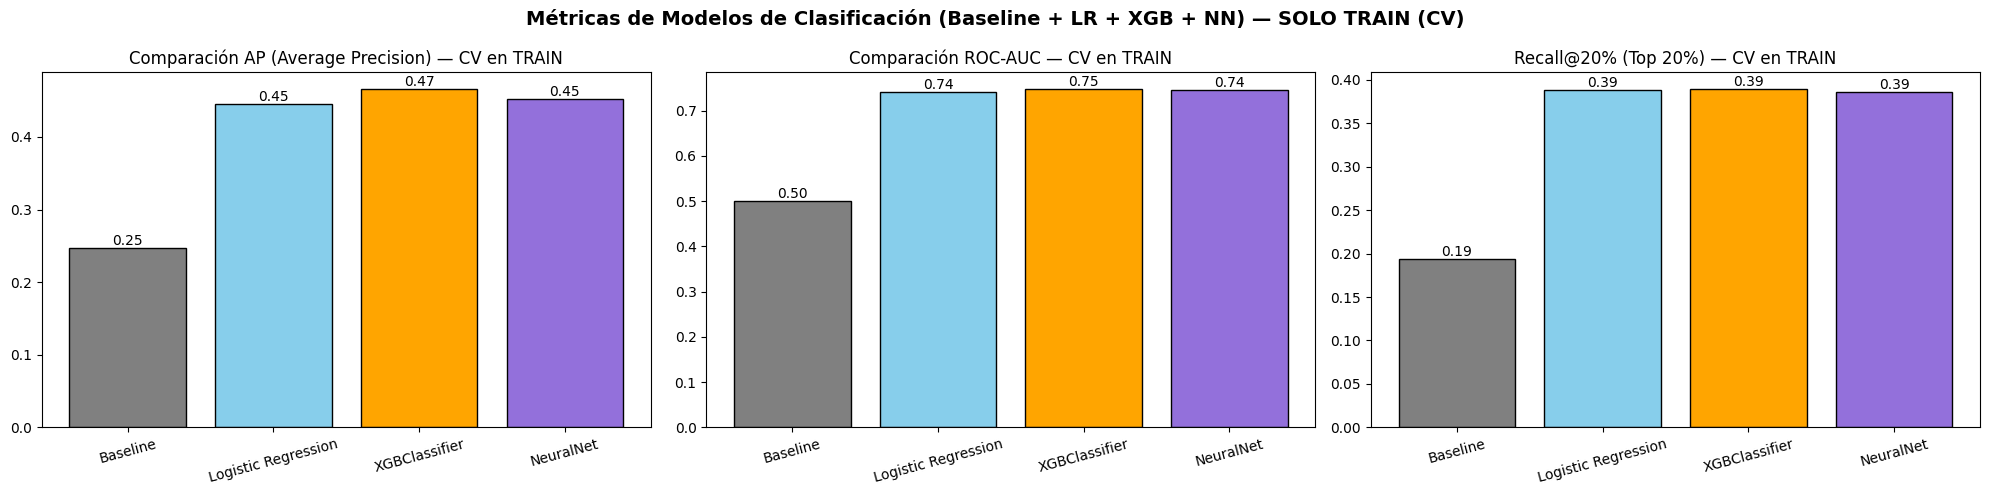

In [14]:
# ============================================================
# CLASIFICACIÓN (Predicción long-stay)
# ============================================================

# -----------------------------
# 1) Baseline (promedio CV en TRAIN) — CLASIFICACIÓN
# -----------------------------
bl_ap, bl_auc, bl_rec = [], [], []
for tr_idx, te_idx in kf.split(train_df_):
    tr_df = train_df_.iloc[tr_idx].copy()
    te_df = train_df_.iloc[te_idx].copy()
    tr_df[TARGET_BIN] = (tr_df[TARGET_REG] > LONG_TH).astype(int)
    te_df[TARGET_BIN] = (te_df[TARGET_REG] > LONG_TH).astype(int)
    cls_metrics, _ = baseline_clasificacion(tr_df, te_df)
    bl_ap.append(cls_metrics["ap"])
    bl_auc.append(cls_metrics["roc_auc"])
    bl_rec.append(cls_metrics["recall_at_20"])

base_cls_metrics = {
    "ap": float(np.mean(bl_ap)),
    "roc_auc": float(np.mean(bl_auc)),
    "recall_at_20": float(np.mean(bl_rec)),
}

# -----------------------------
# 2) Logistic Regression con GridSearchCV (solo TRAIN)
# -----------------------------
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

param_lr = {"model__C": [0.1, 1.0, 3.0], "model__penalty": ["l2"]}

gs_lr = GridSearchCV(
    estimator=logreg,
    param_grid=param_lr,
    scoring="average_precision",
    cv=kf,
    n_jobs=-1,
    refit=True
)
gs_lr.fit(X_train, y_train_bin)
best_lr = gs_lr.best_estimator_

proba_oof_lr = cross_val_predict(best_lr, X_train, y_train_bin, cv=kf, method="predict_proba", n_jobs=-1)[:, 1]
lr_metrics = eval_from_proba(y_train_bin, proba_oof_lr)
print(f"Logistic Regression [CV-Train] best_params={gs_lr.best_params_}  "
      f"AP={lr_metrics['ap']:.4f}  ROC-AUC={lr_metrics['roc_auc']:.4f}  R@20={lr_metrics['recall_at_20']:.4f}")

# ==========================
#  3) NN Classifier (Pipeline)
# ==========================
def build_cls_model(input_dim, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3):
    inp = tf.keras.Input(shape=(input_dim,), name="features")
    x = inp
    for i in range(hidden_layers):
        x = layers.Dense(
            hidden_units, activation="relu",
            kernel_regularizer=regularizers.l2(l2),
            name=f"dense_{i+1}"
        )(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout, name=f"dropout_{i+1}")(x)
    out = layers.Dense(1, activation="sigmoid", name="p")(x)
    model = tf.keras.Model(inp, out, name="nn_classifier")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc"),
                 tf.keras.metrics.AUC(name="pr_auc", curve="PR")]
    )
    return model

class KerasClassifierSK(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4,
                 lr=1e-3, epochs=60, batch_size=256, validation_split=0.1,
                 patience_es=8, patience_rlr=4, verbose=0, random_state=None,
                 use_class_weight=True):
        self.hidden_units = hidden_units
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.l2 = l2
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.patience_es = patience_es
        self.patience_rlr = patience_rlr
        self.verbose = verbose
        self.random_state = random_state
        self.use_class_weight = use_class_weight
        self.model_ = None
        self.input_dim_ = None
        self.class_weight_ = None
        # >>> atributos esperados por sklearn
        self.classes_ = np.array([0, 1], dtype=int)
        self.n_classes_ = 2

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        if self.random_state is not None:
            tf.keras.utils.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        input_dim = X.shape[1]
        if (self.model_ is None) or (self.input_dim_ != input_dim):
            self.model_ = build_cls_model(
                input_dim=input_dim,
                hidden_units=self.hidden_units,
                hidden_layers=self.hidden_layers,
                dropout=self.dropout,
                l2=self.l2,
                lr=self.lr
            )
            self.input_dim_ = input_dim

        cw = None
        if self.use_class_weight:
            y_flat = y.ravel().astype(int)
            classes = np.unique(y_flat)
            weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_flat)
            cw = {int(c): float(w) for c, w in zip(classes, weights)}
            self.class_weight_ = cw

        es  = callbacks.EarlyStopping(monitor="val_loss", patience=self.patience_es, restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=self.patience_rlr, min_lr=1e-5)

        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.validation_split,
            class_weight=cw,
            callbacks=[es, rlr],
            verbose=self.verbose
        )

        self.classes_ = np.array([0, 1], dtype=int)
        self.n_classes_ = 2
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        p1 = self.model_.predict(X, verbose=0).ravel()
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# -----------------------------
# 4) Pipelines de modelos — CLASIFICACIÓN
# -----------------------------
xgb_cls = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        random_state=RANDOM_STATE, n_estimators=150, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, max_depth=4, reg_lambda=1.0,
        eval_metric="logloss"
    ))
])

nn_cls = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_dense", densifier),   # reutiliza el densifier de la Celda 1
    ("model", KerasClassifierSK(
        random_state=RANDOM_STATE,
        epochs=60, batch_size=256, validation_split=0.1,
        hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3,
        use_class_weight=True, verbose=0
    ))
])

models_cls = {
    "Logistic Regression": best_lr,  # del GridSearchCV
    "XGBClassifier":       xgb_cls,
    "NeuralNet":           nn_cls
}

# -----------------------------
# 5) Entrenamiento CV (OOF) y métricas en TRAIN — CLASIFICACIÓN
# -----------------------------
cls_metrics = {}
cls_probas  = {}

for name, pipe in models_cls.items():
    n_jobs_cv = -1 if name != "NeuralNet" else 1  # Keras más seguro en 1 hilo
    proba_oof = cross_val_predict(
        pipe, X_train, y_train_bin, cv=kf, method="predict_proba", n_jobs=n_jobs_cv
    )[:, 1]
    cls_probas[name]  = proba_oof
    cls_metrics[name] = eval_from_proba(y_train_bin, proba_oof)
    print(f"{name} [CV-Train]: AP={cls_metrics[name]['ap']:.4f}  "
          f"ROC-AUC={cls_metrics[name]['roc_auc']:.4f}  R@20={cls_metrics[name]['recall_at_20']:.4f}")

# -----------------------------
# 6) Consolidar con baseline y graficar — CLASIFICACIÓN
# -----------------------------
all_cls_metrics = {"Baseline": base_cls_metrics, **cls_metrics}
desired_order = ["Baseline", "Logistic Regression", "XGBClassifier", "NeuralNet"]
labels_cls = [l for l in desired_order if l in all_cls_metrics]

color_map = {
    "Baseline": "gray",
    "Logistic Regression": "skyblue",
    "XGBClassifier": "orange",
    "NeuralNet": "mediumpurple",
}

x = np.arange(len(labels_cls))
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# AP
ap_values = [all_cls_metrics[l]["ap"] for l in labels_cls]
axes[0].bar(x, ap_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[0].set_title("Comparación AP (Average Precision) — CV en TRAIN")
for i, v in enumerate(ap_values):
    axes[0].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels_cls, rotation=15)

# ROC-AUC
roc_values = [all_cls_metrics[l]["roc_auc"] for l in labels_cls]
axes[1].bar(x, roc_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[1].set_title("Comparación ROC-AUC — CV en TRAIN")
for i, v in enumerate(roc_values):
    axes[1].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels_cls, rotation=15)

# Recall@20%
rec_values = [all_cls_metrics[l]["recall_at_20"] for l in labels_cls]
axes[2].bar(x, rec_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[2].set_title("Recall@20% (Top 20%) — CV en TRAIN")
for i, v in enumerate(rec_values):
    axes[2].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[2].set_xticks(x); axes[2].set_xticklabels(labels_cls, rotation=15)

plt.suptitle("Métricas de Modelos de Clasificación (Baseline + LR + XGB + NN) — SOLO TRAIN (CV)",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 8916, number of used features: 55
[LightGBM] [Info] Start training from score 5.625280
== REGRESIÓN (LGBM) — TEST ==
MAE : 2.0624
RMSE: 2.6780
MAPE: 56.51%

== CLASIFICACIÓN (XGB) — TEST ==
Average Precision (PR-AUC): 0.4869
ROC-AUC                  : 0.7543
Recall@20%               : 0.4261


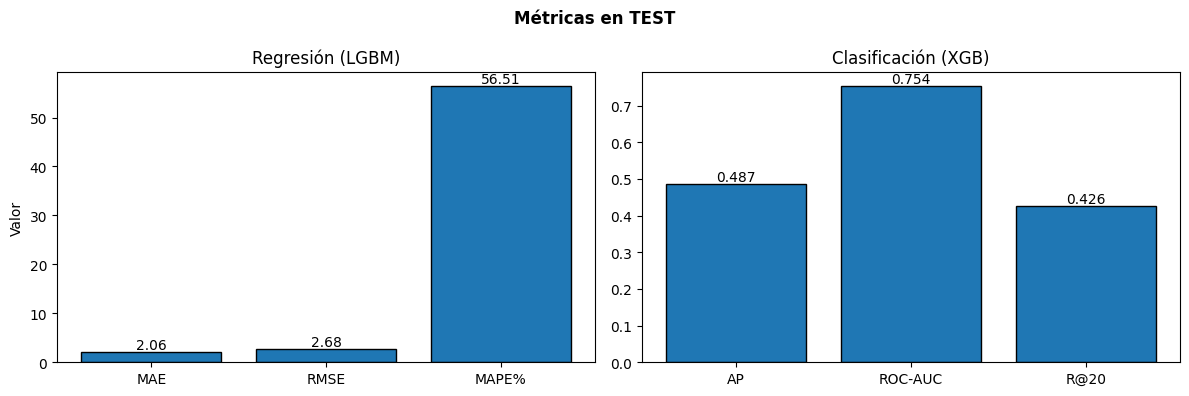

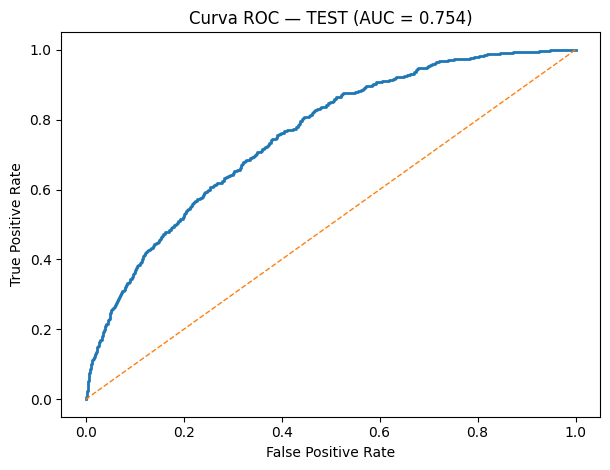

In [15]:
# --- Preparar TEST (y binario fijo si falta) ---
test_df_ = test_df.copy()
if TARGET_BIN not in test_df_.columns:
    test_df_[TARGET_BIN] = (test_df_[TARGET_REG] > LONG_TH).astype(int)

X_test     = test_df_.drop([TARGET_REG, TARGET_BIN], axis=1)
y_test_reg = test_df_[TARGET_REG]
y_test_bin = test_df_[TARGET_BIN].astype(int)

# --- Entrenar en TODO el TRAIN (reusa X_train, y_train_reg, y_train_bin) ---
lgb_reg.fit(X_train, y_train_reg)
xgb_cls.fit(X_train, y_train_bin)

# --- Predicción en TEST ---
# Regresión
y_pred_reg = lgb_reg.predict(X_test)
reg_mae  = mean_absolute_error(y_test_reg, y_pred_reg)
reg_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
reg_mape = mape(y_test_reg, y_pred_reg)

print("== REGRESIÓN (LGBM) — TEST ==")
print(f"MAE : {reg_mae:.4f}")
print(f"RMSE: {reg_rmse:.4f}")
print(f"MAPE: {reg_mape:.2f}%")

# Clasificación
proba_test = xgb_cls.predict_proba(X_test)[:, 1]
cls_metrics = eval_from_proba(y_test_bin, proba_test)  # usa recall@top20% interno
print("\n== CLASIFICACIÓN (XGB) — TEST ==")
print(f"Average Precision (PR-AUC): {cls_metrics['ap']:.4f}")
print(f"ROC-AUC                  : {cls_metrics['roc_auc']:.4f}")
print(f"Recall@20%               : {cls_metrics['recall_at_20']:.4f}")

# --------------------- Gráficos ---------------------
# 1) Barras de métricas (regresión y clasificación)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Métricas en TEST", fontweight="bold")

# Regresión
axes[0].bar(["MAE", "RMSE", "MAPE%"], [reg_mae, reg_rmse, reg_mape], edgecolor="black")
for i, v in enumerate([reg_mae, reg_rmse, reg_mape]):
    axes[0].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_title("Regresión (LGBM)"); axes[0].set_ylabel("Valor")

# Clasificación
vals = [cls_metrics["ap"], cls_metrics["roc_auc"], cls_metrics["recall_at_20"]]
axes[1].bar(["AP", "ROC-AUC", "R@20"], vals, edgecolor="black")
for i, v in enumerate(vals):
    axes[1].text(i, v, f"{v:.3f}", ha="center", va="bottom")
axes[1].set_title("Clasificación (XGB)")
plt.tight_layout()
plt.show()

# Curva ROC (AUC) — Clasificación XGB (TEST)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test_bin, proba_test)
auc_val = roc_auc_score(y_test_bin, proba_test)

plt.figure(figsize=(6.2, 4.8))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC — TEST (AUC = {auc_val:.3f})")
plt.tight_layout()
plt.show()
